In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib

In [ ]:
dataset=pd.read_csv("synthetic_logs.csv")

In [3]:
dataset.head(20)

,timestamp,source,log_message,target_label,complexity
0,2025-06-27 07:20:25,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,bert
1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,bert
2,1/17/2025 1:29,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,bert
3,2025-07-12 00:24:16,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,bert
4,2025-06-02 18:25:23,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,bert
5,2025-10-09 10:30:31,ModernHR,nova.osapi_compute.wsgi.server [req-f0bffbc3-5...,HTTP Status,bert
6,3/1/2025 19:14,ModernHR,Shard 6 replication task ended in failure,Error,bert
7,10/11/2025 8:44,ModernHR,File data_6169.csv uploaded successfully by us...,System Notification,regex
8,2025-02-12 10:42:29,ThirdPartyAPI,nova.compute.claims [req-a07ac654-8e81-416d-bf...,Resource Usage,bert
9,2025-03-30 04:01:45,ModernHR,nova.osapi_compute.wsgi.server [req-2bf7cfee-a...,HTTP Status,bert


In [4]:
dataset['target_label'].value_counts()

target_label
HTTP Status            1017
Security Alert          371
System Notification     356
Error                   177
Resource Usage          177
Critical Error          161
User Action             144
Workflow Error            4
Deprecation Warning       3
Name: count, dtype: int64

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2410 entries, 0 to 2409
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   timestamp     2410 non-null   object
 1   source        2410 non-null   object
 2   log_message   2410 non-null   object
 3   target_label  2410 non-null   object
 4   complexity    2410 non-null   object
dtypes: object(5)
memory usage: 94.3+ KB


In [6]:
dataset['source'].value_counts()

source
ThirdPartyAPI      496
ModernHR           492
BillingSystem      479
AnalyticsEngine    471
ModernCRM          465
LegacyCRM            7
Name: count, dtype: int64

In [7]:
a = dataset['log_message']
n = 0
strn = ''
for i in a:
    b = len(i.split())
    if b>n:
        n=b
        strn=i
print(n)
print(strn)

20
nova.osapi_compute.wsgi.server [req-4895c258-b2f8-488f-a2a3-4fae63982e48 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - -] 10.11.10.1 "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/detail HTTP/1.1" HTTP status code -  200 len: 211 time: 0.0968180


In [8]:
dataset['complexity'].value_counts(())

complexity
bert     1903
regex     500
llm         7
Name: count, dtype: int64

In [9]:
dataset['log_message'].value_counts()

log_message
Backup completed successfully.                                                                                                                                                                                                                                           60
Disk cleanup completed successfully.                                                                                                                                                                                                                                     51
nova.compute.resource_tracker [req-addc1839-2ed5-4778-b57e-5854eb7b8b09 - - - - -] Total usable vcpus: 16, total allocated vcpus: 1                                                                                                                                       9
nova.compute.resource_tracker [req-addc1839-2ed5-4778-b57e-5854eb7b8b09 - - - - -] Final resource view: name=cp-1.slowvm1.tcloud-pg0.utah.cloudlab.us phys_ram=64172MB used_ram=2560MB p

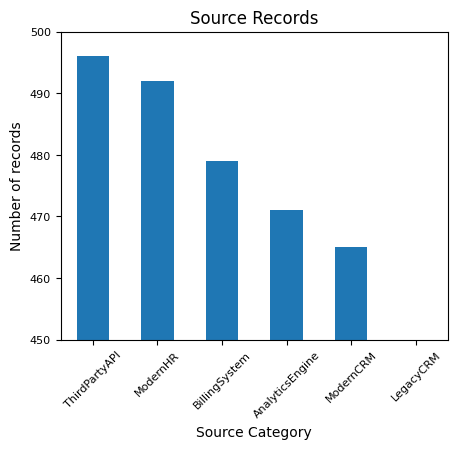

In [10]:
plt.figure(figsize=(5,4))
(dataset['source'].value_counts()).plot(kind='bar',width=0.5,fontsize=8)
plt.ylim(450,500)
plt.title('Source Records')
plt.xlabel('Source Category')
plt.xticks(rotation=45)
plt.ylabel('Number of records')
plt.show()

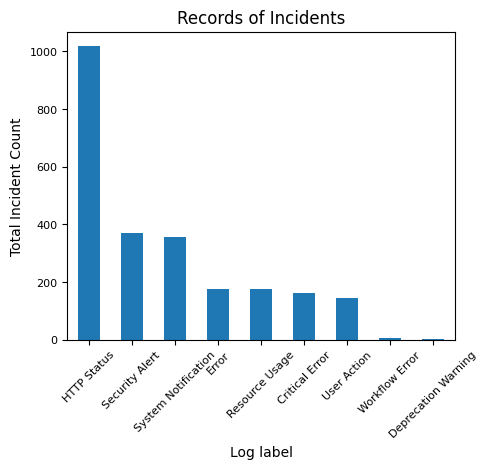

In [11]:
plt.figure(figsize=(5,4))
(dataset['target_label'].value_counts()).plot(kind='bar',width=0.5,fontsize=8)
plt.title('Records of Incidents')
plt.xlabel('Log label')
plt.xticks(rotation=45)
plt.ylabel('Total Incident Count')
plt.show()

Text(0.5, 1.0, 'Source Incident Counts Under the Target Labels')

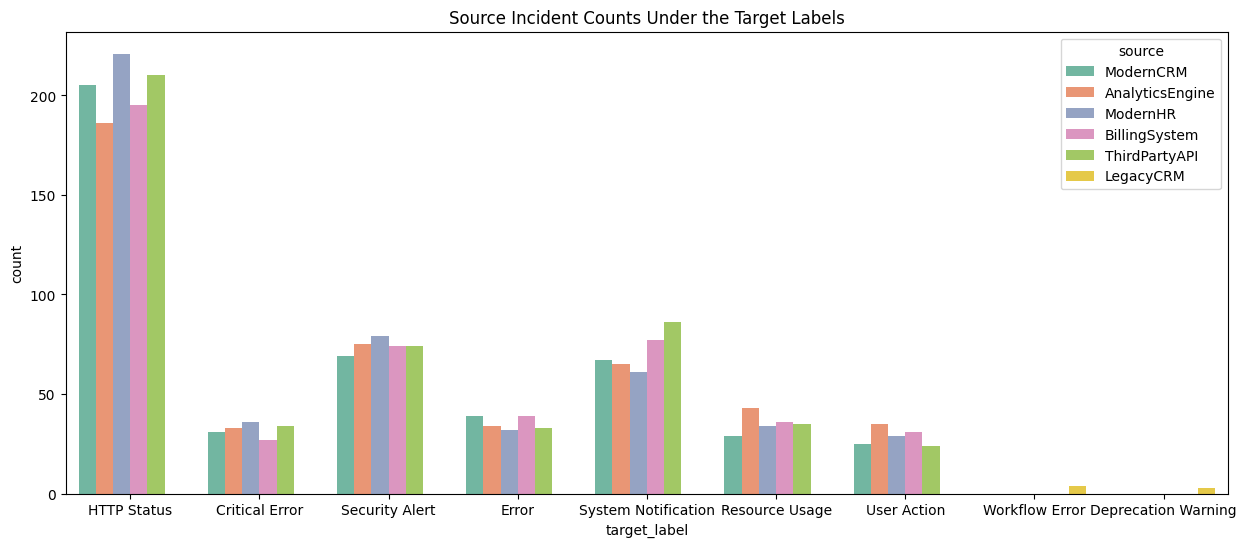

In [12]:
plt.figure(figsize=(15, 6))
sns.countplot(data=dataset, x='target_label', hue='source', palette='Set2')
plt.title("Source Incident Counts Under the Target Labels")

In [13]:
dataset.target_label.unique()

array(['HTTP Status', 'Critical Error', 'Security Alert', 'Error',
       'System Notification', 'Resource Usage', 'User Action',
       'Workflow Error', 'Deprecation Warning'], dtype=object)

In [14]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [15]:
embeddings = model.encode(dataset['log_message'].tolist())

In [110]:
print(embeddings.shape)

(2410, 384)


In [17]:
dbscan = DBSCAN(eps=0.2,min_samples=2,metric='cosine')
clusters = dbscan.fit_predict(embeddings)
dataset['cluster'] = clusters

In [18]:
dataset[dataset['cluster']==1].head(10)

,timestamp,source,log_message,target_label,complexity,cluster
1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,bert,1
10,8/9/2025 18:58,ModernCRM,Email server encountered a sending fault,Error,bert,1
217,1/22/2025 5:45,BillingSystem,Mail service encountered a delivery glitch,Error,bert,1
248,5/2/2025 23:04,ModernHR,Service disruption caused by email sending error,Critical Error,bert,1
265,3/30/2025 23:53,ModernCRM,Email system had a problem sending emails,Error,bert,1
361,11/19/2025 23:06,BillingSystem,Email service experienced a sending issue,Error,bert,1
450,10/27/2025 5:59,ThirdPartyAPI,Email delivery system encountered an error,Error,bert,1
477,12/2/2025 10:30,AnalyticsEngine,Email transmission error caused service impact,Critical Error,bert,1
570,11/7/2025 18:08,ThirdPartyAPI,Email service impacted by sending failure,Critical Error,bert,1
678,4/28/2025 15:13,AnalyticsEngine,Email delivery problem affected system,Critical Error,bert,1


In [19]:
cluster_count = dataset['cluster'].value_counts()
large_clusters = cluster_count[cluster_count>10].index

In [20]:
large_clusters

Index([ 0,  5, 11, 13,  7,  8, 21,  3,  4, 17, 30,  6, 20, 16, -1,  9,  1, 10,
       32, 47, 14, 46, 18, 24, 39, 52, 25],
      dtype='int64', name='cluster')

In [21]:
for cluster in large_clusters:
    print(f'Cluster {cluster}:')
    print(dataset[dataset['cluster']==cluster]['log_message'].head(5).to_string(index=True))
    print()

Cluster 0:
0    nova.osapi_compute.wsgi.server [req-b9718cd8-f...
3    nova.osapi_compute.wsgi.server [req-4895c258-b...
4    nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...
5    nova.osapi_compute.wsgi.server [req-f0bffbc3-5...
9    nova.osapi_compute.wsgi.server [req-2bf7cfee-a...

Cluster 5:
8     nova.compute.claims [req-a07ac654-8e81-416d-bf...
26    nova.compute.claims [req-d6986b54-3735-4a42-90...
40    nova.compute.claims [req-72b4858f-049e-49e1-b3...
58    nova.compute.claims [req-5c8f52bd-8e3c-41f0-95...
61    nova.compute.claims [req-d38f479d-9bb9-4276-96...

Cluster 11:
27     User User685 logged out.
57      User User395 logged in.
85      User User225 logged in.
88     User User494 logged out.
126     User User900 logged in.

Cluster 13:
30     Backup started at 2025-05-14 07:06:55.
44     Backup started at 2025-02-15 20:00:19.
108      Backup ended at 2025-08-08 13:06:23.
128    Backup started at 2025-11-14 08:27:43.
191    Backup started at 2025-12-09 10:19:11.

Clust

In [64]:
def classify_with_regex(log_message):
    label_patterns = {
        r"User User\d+ logged (in|out).":"User Action",
        r"Backup (started|ended) at.*":"System Notification",
        r"Backup completed successfully.":"System Notification",
        r"System updated to version.*":"System Notification",
        r"File.*uploaded successfully by user.*":"System Notification",
        r"Disk cleanup completed successfully.":"System Notification",
        r"System reboot initiated by user.*":"System Notification",
        r"Account with ID .*created by.*":"User Action",
                
        
    }
    for pattern, label in label_patterns.items():
        #if re.search(pattern,log_message):
        if re.search(pattern,log_message,re.IGNORECASE):
                return label
    return None
        

In [65]:
classify_with_regex("system reboot initiated by user User243")

'System Notification'

In [66]:
dataset['regex_label']=dataset['log_message'].apply(classify_with_regex)

In [67]:
dataset[dataset.regex_label=="System Notification"].head()

,timestamp,source,log_message,target_label,complexity,cluster,regex_label
7,10/11/2025 8:44,ModernHR,File data_6169.csv uploaded successfully by us...,System Notification,regex,4,System Notification
14,1/4/2025 1:43,ThirdPartyAPI,File data_3847.csv uploaded successfully by us...,System Notification,regex,4,System Notification
15,5/1/2025 9:41,ModernCRM,Backup completed successfully.,System Notification,regex,8,System Notification
30,4/26/2025 7:54,AnalyticsEngine,Backup started at 2025-05-14 07:06:55.,System Notification,regex,13,System Notification
36,11/19/2025 13:14,BillingSystem,System reboot initiated by user User243.,System Notification,regex,16,System Notification


In [68]:
dataset[dataset.regex_label.isna()]
#the log messages not having a pattern in the sentence is labled as None in the regex label.
#therefore, these non labeled messages need to be properly classified.
#there are 2021 log_messages not labeled to any category 

,timestamp,source,log_message,target_label,complexity,cluster,regex_label
0,2025-06-27 07:20:25,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,bert,0,None
1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,bert,1,None
2,1/17/2025 1:29,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,bert,2,None
3,2025-07-12 00:24:16,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,bert,0,None
4,2025-06-02 18:25:23,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,bert,0,None
...,...,...,...,...,...,...,...
2405,2025-08-13 07:29:25,ModernHR,nova.osapi_compute.wsgi.server [req-96c3ec98-2...,HTTP Status,bert,0,None
2406,1/11/2025 5:32,ModernHR,User 3844 account experienced multiple failed ...,Security Alert,bert,7,None
2407,2025-08-03 03:07:47,ThirdPartyAPI,nova.metadata.wsgi.server [req-b6d4a270-accb-4...,HTTP Status,bert,0,None
2408,11/11/2025 11:52,BillingSystem,Email service affected by failed transmission,Critical Error,bert,1,None


In [69]:
dataset[dataset.regex_label.notnull()]
#the count of labeled message with regex is 389. this is small number of messages compared to the complete data set.

,timestamp,source,log_message,target_label,complexity,cluster,regex_label
7,10/11/2025 8:44,ModernHR,File data_6169.csv uploaded successfully by us...,System Notification,regex,4,System Notification
14,1/4/2025 1:43,ThirdPartyAPI,File data_3847.csv uploaded successfully by us...,System Notification,regex,4,System Notification
15,5/1/2025 9:41,ModernCRM,Backup completed successfully.,System Notification,regex,8,System Notification
18,2/22/2025 17:49,ModernCRM,Account with ID 5351 created by User634.,User Action,regex,9,User Action
27,9/24/2025 19:57,ThirdPartyAPI,User User685 logged out.,User Action,regex,11,User Action
...,...,...,...,...,...,...,...
2376,6/27/2025 8:47,ModernCRM,System updated to version 2.0.5.,System Notification,regex,21,System Notification
2381,9/5/2025 6:39,ThirdPartyAPI,Disk cleanup completed successfully.,System Notification,regex,30,System Notification
2394,4/3/2025 13:13,ModernHR,Disk cleanup completed successfully.,System Notification,regex,30,System Notification
2395,5/2/2025 14:29,ThirdPartyAPI,Backup ended at 2025-05-06 11:23:16.,System Notification,regex,13,System Notification


In [70]:
dataset.regex_label.value_counts()

regex_label
System Notification    356
User Action            144
Name: count, dtype: int64

In [71]:
dataset[dataset.regex_label!=dataset.complexity].shape

(2410, 7)

In [72]:
dataset[dataset.regex_label.isna()]['complexity'].value_counts()

complexity
bert    1903
llm        7
Name: count, dtype: int64

In [77]:
not_classified = pd.DataFrame(dataset[dataset.regex_label.isna()])
not_classified.head()

,timestamp,source,log_message,target_label,complexity,cluster,regex_label
0,2025-06-27 07:20:25,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,bert,0,None
1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,bert,1,None
2,1/17/2025 1:29,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,bert,2,None
3,2025-07-12 00:24:16,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,bert,0,None
4,2025-06-02 18:25:23,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,bert,0,None


In [ ]:
#the records of  workflow error and depreciation warning is much lesser than the other labels.
#therefore these are needed to be classified using llm.
#other part having the big chunk of not classified using the regex. it will be classified using bert model.

not_classified['target_label'].value_counts()[not_classified['target_label'].value_counts()<=5].index.to_list()

['Workflow Error', 'Deprecation Warning']

In [90]:
not_classified['target_label'].value_counts()[not_classified['target_label'].value_counts()<=5]

target_label
Workflow Error         4
Deprecation Warning    3
Name: count, dtype: int64

In [96]:
not_classified[not_classified['target_label']=='Workflow Error']

,timestamp,source,log_message,target_label,complexity,cluster,regex_label
60,2025-10-06 16:55:23,LegacyCRM,Lead conversion failed for prospect ID 7842 du...,Workflow Error,llm,-1,None
377,2025-06-24 12:16:29,LegacyCRM,Customer follow-up process for lead ID 5621 fa...,Workflow Error,llm,-1,None
1325,2025-04-17 07:33:44,LegacyCRM,Escalation rule execution failed for ticket ID...,Workflow Error,llm,-1,None
2217,2025-05-12 09:46:54,LegacyCRM,Task assignment for TeamID 3425 could not comp...,Workflow Error,llm,-1,None


In [ ]:
#the legacycrm is the source of target label workflow error and deprecation warning
#except this part, i use a new data set using remain in the not_classified data set
not_classified[not_classified['target_label']=='Deprecation Warning']

,timestamp,source,log_message,target_label,complexity,cluster,regex_label
255,2025-05-03 16:55:35,LegacyCRM,API endpoint 'getCustomerDetails' is deprecate...,Deprecation Warning,llm,-1,None
1734,2025-04-30 07:47:30,LegacyCRM,The 'ExportToCSV' feature is outdated. Please ...,Deprecation Warning,llm,-1,None
1826,2025-01-23 10:33:36,LegacyCRM,Support for legacy authentication methods will...,Deprecation Warning,llm,-1,None


In [107]:
bert_df = not_classified[not_classified['source']!='LegacyCRM']
llm_df = not_classified[not_classified['source']=='LegacyCRM']

In [109]:
bert_df

,timestamp,source,log_message,target_label,complexity,cluster,regex_label
0,2025-06-27 07:20:25,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,bert,0,None
1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,bert,1,None
2,1/17/2025 1:29,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,bert,2,None
3,2025-07-12 00:24:16,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,bert,0,None
4,2025-06-02 18:25:23,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,bert,0,None
...,...,...,...,...,...,...,...
2405,2025-08-13 07:29:25,ModernHR,nova.osapi_compute.wsgi.server [req-96c3ec98-2...,HTTP Status,bert,0,None
2406,1/11/2025 5:32,ModernHR,User 3844 account experienced multiple failed ...,Security Alert,bert,7,None
2407,2025-08-03 03:07:47,ThirdPartyAPI,nova.metadata.wsgi.server [req-b6d4a270-accb-4...,HTTP Status,bert,0,None
2408,11/11/2025 11:52,BillingSystem,Email service affected by failed transmission,Critical Error,bert,1,None


In [112]:
bert_embedding = model.encode(bert_df['log_message'].to_list())

In [119]:
X=bert_embedding
Y=bert_df['target_label']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,random_state=123)

lrm = LogisticRegression(max_iter=1000)
his = lrm.fit(X_train,Y_train)

In [ ]:
y_pred = his.predict(X_test)
report = classification_report(Y_test,y_pred)
print(report)

                precision    recall  f1-score   support

Critical Error       1.00      1.00      1.00        47
         Error       0.98      1.00      0.99        54
   HTTP Status       1.00      1.00      1.00       309
Resource Usage       1.00      1.00      1.00        53
Security Alert       1.00      0.99      1.00       108

      accuracy                           1.00       571
     macro avg       1.00      1.00      1.00       571
  weighted avg       1.00      1.00      1.00       571



In [ ]:
joblib.dump(his,'../models/logistic_classifier.joblib')

['../models/logistic_classifier.joblib']